In [1]:
from model.classification_model import ClassifierModel # class with classifiers
from model.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from plot_settings import * # plot configuration 

ide_plot() #plot for github dark theme

import joblib
from copy import deepcopy
import seaborn as sns

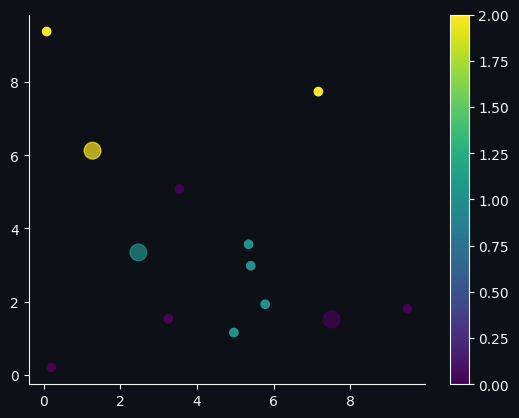

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

points = np.random.uniform(0,10, size = (10,2))

labels = np.random.randint(0,3, size = 10)

extraPoints = np.random.uniform(0,10, size = (3,2))

sc = plt.scatter(points[:,0], points[:,1], c = labels) 
sc2 = plt.scatter(extraPoints[:,0], extraPoints[:,1], s = 144, alpha = 0.7, 
            c = np.arange(len(extraPoints)))

plt.colorbar(sc)

plt.show()

In [3]:
plt.rcParams["axes.facecolor"] = 'w'
plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["axes.labelcolor"] = 'black'
plt.rcParams["grid.color"] = 'black'
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.labelcolor"] = 'black'
plt.rcParams["axes.titlecolor"] = 'black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['g', 'r', 'b', 'y'])

In [4]:
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [5]:
reduce_model = joblib.load("best/reduce_model.pkl")
c_model = joblib.load("best/c_model.pkl")

In [6]:
main_reduced = reduce_model.transform(dataset)

In [11]:
def clf_per_seed(n=10, metric = ClassifierModel.score):
    clfs = deepcopy(c_model)
    result = {name: [0.]*n for name in clfs.models}
    result["Median"] = [0.]*n
    for seed in range(0, n):
        X_train, X_test, y_train, y_test = train_test_split(
        main_reduced, target.values.ravel(), test_size=0.2, random_state=seed,
        #stratify=target.values.ravel()
        )
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for clf in clfs.models:
            clfs.models[clf].fit(X_train, y_train)
            result[clf][seed] = metric(y_test, clfs.models[clf].predict(X_test))
        result["Median"][seed] = metric(y_test, np.ones_like(y_test)*np.median(y_test))
    return result

    

In [12]:
r = pd.DataFrame(clf_per_seed(50))
print(r.mean())
print(r.std())

CatBoost    0.690237
RF          0.679243
AdaBoost    0.589854
Knn         0.743401
Median      0.294868
dtype: float64
CatBoost    0.108048
RF          0.116853
AdaBoost    0.114440
Knn         0.109033
Median      0.037265
dtype: float64


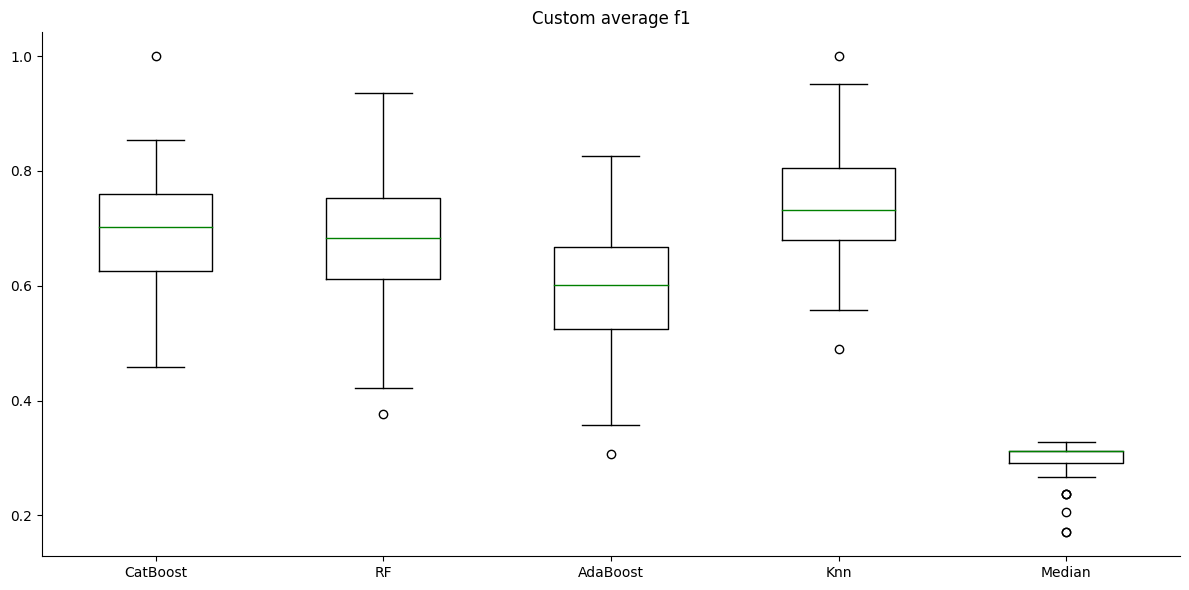

In [15]:


plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="black"),
            capprops=dict(color="black"),
            whiskerprops=dict(color="black"),
            medianprops=dict(color="g"),
            flierprops=dict(color="black", markeredgecolor="black"),
            )
plt.title("Custom average f1")
plt.tight_layout()
plt.show()

CatBoost    0.705505
RF          0.696390
AdaBoost    0.608604
Knn         0.755671
Median      0.374193
dtype: float64
CatBoost    0.103875
RF          0.112133
AdaBoost    0.109061
Knn         0.104110
Median      0.026816
dtype: float64


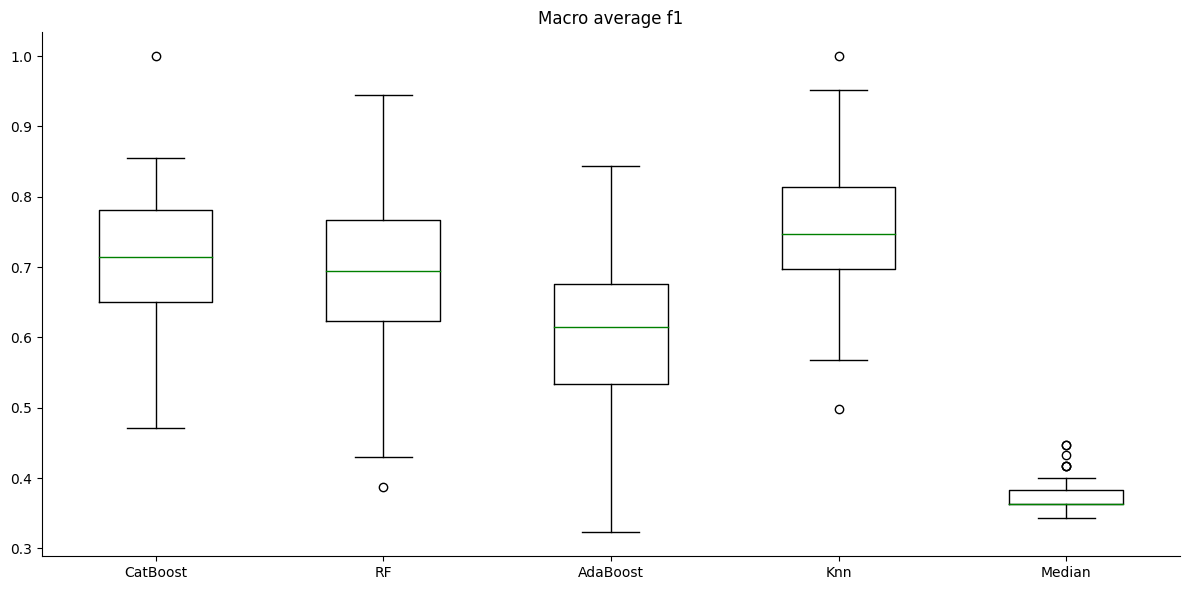

In [18]:
r = pd.DataFrame(clf_per_seed(50, lambda y_t, y_p: metrics.f1_score(y_t, y_p, average="macro")))
print(r.mean())
print(r.std())
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="black"),
            capprops=dict(color="black"),
            whiskerprops=dict(color="black"),
            medianprops=dict(color="g"),
            flierprops=dict(color="black", markeredgecolor="black"),
            )
plt.title("Macro average f1")
plt.tight_layout()
plt.show()

CatBoost    0.632985
RF          0.617729
AdaBoost    0.511252
Knn         0.709593
Median      0.042045
dtype: float64
CatBoost    0.135889
RF          0.152894
AdaBoost    0.169154
Knn         0.132223
Median      0.168174
dtype: float64


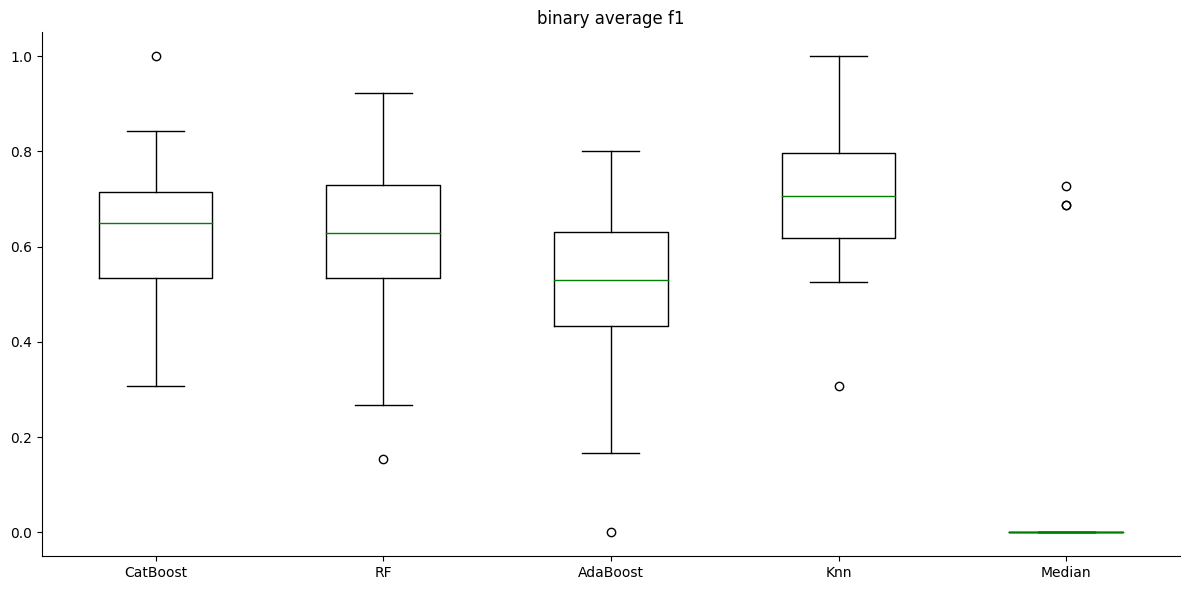

In [17]:
r = pd.DataFrame(clf_per_seed(50, lambda y_t, y_p: metrics.f1_score(y_t, y_p, pos_label=1)))
print(r.mean())
print(r.std())
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="black"),
            capprops=dict(color="black"),
            whiskerprops=dict(color="black"),
            medianprops=dict(color="g"),
            flierprops=dict(color="black", markeredgecolor="black"),
            )
plt.title("binary average f1")
plt.tight_layout()
plt.show()

In [11]:
def clf_per_ls_dim(dim):
    reduce_model = ReduceModel(model="AE", layers=(1169, 500, 200, dim))
    reduce_model.train(epochs=60, lr=1e-3)

    main_reduced = reduce_model.transform(dataset)

    X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0,
    #stratify=target.values.ravel()
    )

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    c_model = ClassifierModel()
    res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)
    c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})
    c_model.fit(X_train, y_train)
    res = {"model": deepcopy(c_model),
                "data": [X_train, X_test, y_train, y_test]}
    for name in c_model.models:
        pred = c_model.models[name].predict(X_test)
        print(f"report for {name}: {c_model.score(y_test, pred):.2f}")
        print(metrics.classification_report(y_test, pred))
    return res

In [12]:
store = {i: clf_per_ls_dim(i) for i in [40, 30, 20, 10, 8, 6, 5, 2]}


Sequential(
  (0): Linear(in_features=1169, out_features=500, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=500, out_features=200, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=200, out_features=40, bias=True)
)
Sequential(
  (0): Linear(in_features=40, out_features=200, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=200, out_features=500, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=500, out_features=1169, bias=True)
)


  0%|          | 0/60 [00:00<?, ?it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\droid\AppData\Local\Temp\ipykernel_14764\2428528622.py", line 1, in <module>
    store = {i: clf_per_ls_dim(i) for i in [40, 30, 20, 10, 8, 6, 5, 2]}
  File "C:\Users\droid\AppData\Local\Temp\ipykernel_14764\2428528622.py", line 1, in <dictcomp>
    store = {i: clf_per_ls_dim(i) for i in [40, 30, 20, 10, 8, 6, 5, 2]}
  File "C:\Users\droid\AppData\Local\Temp\ipykernel_14764\2347309297.py", line 3, in clf_per_ls_dim
    reduce_model.train(epochs=60, lr=1e-3)
  File "c:\Users\droid\Projects\phase_transmition_ML\model\reduce_model.py", line 487, in train
    self.train_results = self.model._train(self.train_set,
  File "c:\Users\droid\Projects\phase_transmition_ML\model\reduce_model.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0,
    #stratify=target.values.ravel()
    )

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
for name in ClassifierModel.clf_dict.keys():
    plt.plot(store.keys(), [ClassifierModel.score(store[dim]["data"][3], store[dim]["model"].models[name].predict(store[dim]["data"][1])) for dim in store.keys()], label=name)

plt.legend()
plt.title("Custom f1")
plt.show()


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\droid\AppData\Local\Temp\ipykernel_14764\1409610510.py", line 2, in <module>
    plt.plot(store.keys(), [ClassifierModel.score(store[dim]["data"][3], store[dim]["model"].models[name].predict(store[dim]["data"][1])) for dim in store.keys()], label=name)
NameError: name 'store' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\droid\AppData\

In [15]:
for name in ClassifierModel.clf_dict.keys():
    plt.plot(store.keys(), [metrics.f1_score(store[dim]["data"][3], store[dim]["model"].models[name].predict(store[dim]["data"][1]), average="weighted") for dim in store.keys()], label=name)

plt.legend()
plt.title("weighted f1")
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\droid\AppData\Local\Temp\ipykernel_14764\3598658418.py", line 2, in <module>
    plt.plot(store.keys(), [metrics.f1_score(store[dim]["data"][3], store[dim]["model"].models[name].predict(store[dim]["data"][1]), average="weighted") for dim in store.keys()], label=name)
NameError: name 'store' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users